This notebook is a tutorial for training and prediction in data1.

# Load Dependencies

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import tensorflow as tf
from script.MIGNN_model import Graph_DataLoader,MIGNN_model1
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

2022-08-16 21:34:04.120337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 21:34:04.120995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 21:34:04.121193: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/anaconda3/lib/python3.8/site-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-mem

# Load Steric and Electronic Information

In [7]:
react_spms = np.load('./data1/run_data/data1_SEMG_MIGNN_react_spms.npy')
react_elec = np.load('./data1/run_data/data1_SEMG_MIGNN_react_elec.npy')
labels = np.load('./data1/run_data/data1_SEMG_MIGNN_labels.npy')
label_std = np.load('./data1/run_data/data1_SEMG_MIGNN_label_std.npy')

# Train Model

In [3]:
batch_size = 128
np.random.seed(2021)
shuffle = np.array(list(range(len(react_spms))))
np.random.shuffle(shuffle)
train_index = shuffle[:int(0.7*len(react_spms))]
val_index = shuffle[int(0.7*len(react_spms)):]
spms_train,elec_train,y_train = react_spms[train_index],react_elec[train_index],label_std[train_index]
spms_val,elec_val,y_val = react_spms[val_index],react_elec[val_index],label_std[val_index]

train_gen = Graph_DataLoader(spms_train,elec_train,y_train,batch_size=batch_size)
valid_gen = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size)
valid_gen_predict = Graph_DataLoader(spms_val,elec_val,y_val,batch_size=batch_size,predict=True)
opt = tf.keras.optimizers.Adam()

In [5]:
model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=0,hidden_size=128,final_act='sigmoid')

model.compile(optimizer=opt,loss='mse')
checkpoint = tf.train.Checkpoint(myAwesomeModel=model)
EPOCHS = 70
for epoch in range(EPOCHS):
    hist = model.fit(train_gen,validation_data=valid_gen)
    path = checkpoint.save('./data1/run_data/data1_random.ckpt')
    print("model saved to %s" % path)  

22/22 [==============================] - 13s 478ms/step - loss: 0.0611 - val_loss: 0.0652
model saved to ./data1/run_data/data1_random.ckpt-1
22/22 [==============================] - 10s 457ms/step - loss: 0.0351 - val_loss: 0.0447
model saved to ./data1/run_data/data1_random.ckpt-2
22/22 [==============================] - 10s 452ms/step - loss: 0.0206 - val_loss: 0.0365
model saved to ./data1/run_data/data1_random.ckpt-3
22/22 [==============================] - 10s 456ms/step - loss: 0.0160 - val_loss: 0.0329
model saved to ./data1/run_data/data1_random.ckpt-4
22/22 [==============================] - 10s 451ms/step - loss: 0.0131 - val_loss: 0.0291
model saved to ./data1/run_data/data1_random.ckpt-5
22/22 [==============================] - 10s 451ms/step - loss: 0.0108 - val_loss: 0.0259
model saved to ./data1/run_data/data1_random.ckpt-6
22/22 [==============================] - 10s 445ms/step - loss: 0.0100 - val_loss: 0.0261
model saved to ./data1/run_data/data1_random.ckpt-7
22/22 

In [27]:
new_model = MIGNN_model1(107, 36, 56, 18,linear_depth=4,atom_attention=1,inter_attention=1,
                    end_attention=0,hidden_size=128,final_act='sigmoid')
new_model.compile(optimizer=opt,loss='mse')

checkpoint = tf.train.Checkpoint(myAwesomeModel=new_model) 
checkpoint.restore('./data1/run_data/data1_random.ckpt-70') # 46
_ = new_model.fit(valid_gen,epochs=1)
y_pred = new_model.predict(valid_gen_predict)
y_val=label_std[val_index]
y_val=y_val*(labels.max()-labels.min())+labels.min()
y_pred=y_pred*(labels.max()-labels.min())+labels.min()

10/10 [==============================] - 6s 338ms/step - loss: 0.0057


# Results

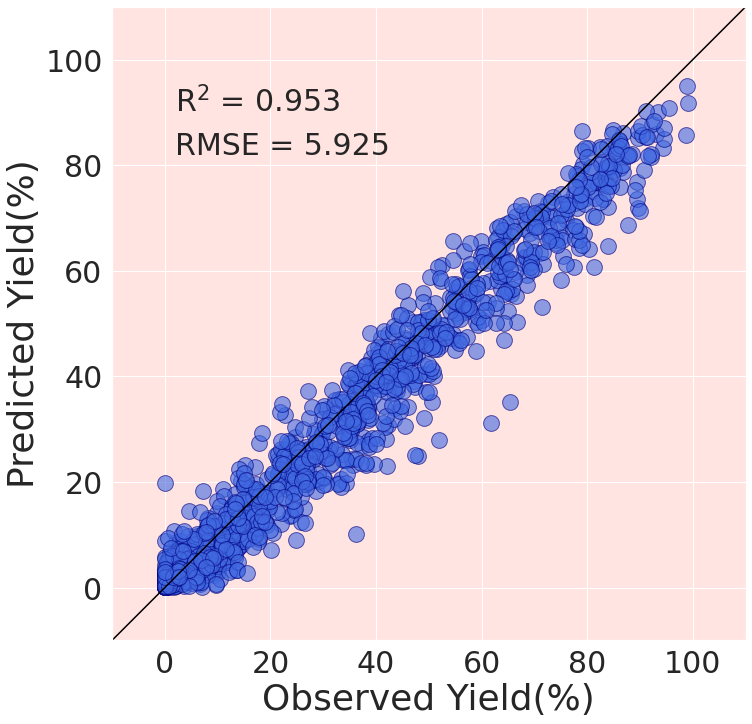

In [24]:
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')#royalblue
plt.plot([-20,120],[-20,120],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.set_facecolor('mistyrose')
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [26]:
np.save('./result/data1_SEMG_MIGNN_y_val.npy',y_val)
np.save('./result/data1_SEMG_MIGNN_y_pred.npy',y_pred)